Importamos la librerias

In [1]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

# matplotlib lo vamos a utilizar para realizar una ''animación'' de mi modelo.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Definimos otros paquete que vamos a usar para medir el tiempo de ejecución del modelo
import time
import datetime
import random

import json
import math

from flask import Flask

In [2]:
ActiveSimulation=False
GRID_WIDTH= 100
GRID_HIGHT= 200
MAX_GENERATION= 200
NUM_CARS=1
CARS_GENERATED_BY_STEP = 3

In [3]:
def get_grid(model):
    grid = np.zeros((model.grid.height, model.grid.width))
    for ren in range(model.grid.height):
        for col in range(model.grid.width):
            if model.grid.is_cell_empty((col, ren)):
                grid[ren][col] = 0
            else:
                grid[ren][col] = 1
            
    return grid

In [4]:
def get_pos(agent):
    return [agent.my_id,agent.x,agent.y]

Definimos el agente 

In [5]:
class CarAgent(Agent):
    def __init__(self, unique_id, model,x,y,state, line):
        super().__init__(unique_id, model)
        #Position
        self.x=int(x)
        self.y=int(y)
        #Velocity
        self.xvelocity=0
        self.yvelocity=model.speedWayVelocity
        self.visionRange=6
        #States : stop , go , change
        self.state=state
        #Valor de x al que tienes que ir
        self.line=line
        self.my_id=unique_id
        self.braking=False
        
    def move(self):
        if(ActiveSimulation):
            print("Moving Car %i from (%i,%i) to (%i,%i) velocity= (%i,%i) State:%s"%(self.my_id,self.x,self.y,int(self.xvelocity+self.x),int(self.yvelocity+self.y),self.xvelocity,self.yvelocity,self.state))
        self.y=int(self.yvelocity+self.y)
        self.x=int(self.x+self.xvelocity)
        self.model.grid.move_agent(self, (self.x,self.y))
        
    def canCrash(self):
        
        limit=int(self.y+self.visionRange*self.yvelocity)
        if(limit<25):
            limit=25
        #print("Range %f" % (self.visionRange*self.yvelocity))
        position = []
        
        for i in range(self.y + 1,limit):
            newpos=(self.x, i)
            if(self.model.grid.out_of_bounds(newpos)):
                break
            position.append(newpos)
        return (len(self.model.grid.get_cell_list_contents(position))>0)
        
    
    def brake(self):
        if(self.yvelocity<=4):
            self.yvelocity=0
        self.xvelocity=int(self.xvelocity/2)
        self.yvelocity=int(self.yvelocity/2)
        
        
    def auxReviewLine(self,xvalue):
        dist=model.speedWayVelocity
        backMargin=20
        frontMargin=20
        position = []
        for i in range(int(self.y-backMargin), int( self.y + frontMargin)):
            newpos=(xvalue, i)
            if(model.grid.out_of_bounds(newpos)):
                break
            position.append(newpos)
        return (len(self.model.grid.get_cell_list_contents(position))==0)
            
    def chooseLine(self):
        left=0
        right=0
        myIndexLine=0
        for i in range(len(model.lines)):
            if(model.lines[i]==self.line):
                myIndexLine=i
                break
                
        if(myIndexLine!=2):
            right=self.auxReviewLine(model.lines[myIndexLine+1])
        if(myIndexLine!=0):
            left=self.auxReviewLine(model.lines[myIndexLine-1])
        if(left and right):
            if(np.random.random(1)[0]<=0.5):
                if(ActiveSimulation):
                    print("RANDOM CHOOSE LEFT x= %i"%model.lines[myIndexLine-1])
                return model.lines[myIndexLine-1]
            else:
                if(ActiveSimulation):
                    print("RANDOM CHOOSE RIGHT x= %i"%model.lines[myIndexLine+1])
                return model.lines[myIndexLine+1]
        else:
            if(left):
                return model.lines[myIndexLine-1]
            elif(right):
                return model.lines[myIndexLine+1]
        return 0
    
    def regulateVel(self,targetVel):
        if(self.yvelocity == targetVel):
            return
        elif self.yvelocity >targetVel:
            dif=self.yvelocity-targetVel
            if dif<2:
                self.yvelocity=targetVel
            else:
                self.yvelocity-=(2*dif/3) 
        elif self.yvelocity < targetVel:
            dif=targetVel-self.yvelocity
            if dif<2:
                self.yvelocity=targetVel
            else:
                self.yvelocity +=(2*dif/3) 
                
    def alignLine(self):
        if(self.x == self.line):
            self.xvelocity=0
            return
        elif(self.x<self.line):
            self.xvelocity=1
        elif(self.x>self.line):
            self.xvelocity=1
        

    def step(self):
        if (self.state=="stop"):
            self.brake()
        elif (self.state=="go"):
            self.alignLine()
            if(self.canCrash()):
                if(ActiveSimulation):
                    print("The car %i in the line %i Can Crash aahhh"%(self.my_id,self.line))
                newLine=self.chooseLine()
                if(ActiveSimulation):
                    print("car %i NewLine Decision %i"%(self.my_id,newLine))
                if(newLine != 0):
                    if(ActiveSimulation):
                        print("CHANGING LINE %i to %i"%(self.line,newLine))
                    self.state="changingLine"
                    self.line=newLine
                else:
                    if(ActiveSimulation):
                        print("Car %i can't change line, I'll brake"%(self.my_id))
                    self.brake()
            else:
                self.regulateVel(model.speedWayVelocity)
            
        elif (self.state=="changingLine"):
            self.regulateVel(model.speedWayVelocity)
            if(self.x == self.line):
                if(ActiveSimulation):
                    print("Car %i change line SUCCESS"%self.my_id)
                self.state="go"
                self.xvelocity=0
            elif(self.x<self.line):
                self.xvelocity=5
            elif(self.x>self.line):
                self.xvelocity=-5
            
                    

        #print("POS (%i,%i)"%(self.x,self.y))
        #print("VEL(%i,%i)"%(self.xvelocity,self.yvelocity))
       
        self.move()

 

Definimos el modelo

In [6]:
class highwayModel(Model):
    def __init__(self,n, widht, height,num_generated_cars):
        self.agentId=100;
        self.num_agents = n
        self.grid=SingleGrid(widht,height,True)
        self.schedule = SimultaneousActivation(self)
        self.lines=[20,50,80]
        self.currentStep=0
        
        self.idCounter=0
        
        self.speedWayVelocity=6
        #Generate Cars
        self.generatorTime= 8
        #numero de carros
        self.numCarsGenerated = num_generated_cars
        #Incident
        self.incidentStopCar=False
        self.startIncident=20
        self.time=0
        
        for i in range(self.num_agents):
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
        
            a = CarAgent(self.newId(), self,x,y,"go",20)
            self.schedule.add(a)  
            self.grid.place_agent(a, (x, y))
        #self.createBarrier()
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid},agent_reporters={"Positions": get_pos})
        
    def newId(self):
        self.idCounter+=1
        return self.idCounter
    
    def deleteCarOutLimits(self):
        ###  Cambiar este ciclo por recorrer la agenda
        for (agent, x, y) in self.grid.coord_iter():
            if not model.grid.is_cell_empty((x, y)):
                #print("Car position (%i, %i)"%(x,y))
                if agent.x<0 or agent.x>=self.grid.width or agent.y<0 or agent.y>=self.grid.height:
                    #print("Car with (%i, %i) is out of the limits"%(x,y))
                    self.grid.remove_agent(agent)
                    self.schedule.remove(agent)
                    #print("Car with (%i, %i) was deleted"%(x,y))
                
    def generateNewCar(self,numCars,generatorTime):
        
        if( self.currentStep%generatorTime==2):
            x=self.lines
            random.shuffle(x)
            #print("New car in %i %i"%(x,0))
            for i in range(numCars):
                a = CarAgent(self.newId(), self,x[i] ,0,"go",x[i])
                self.schedule.add(a)
                self.grid.place_agent(a, (x[i], 0))
    
    def carPositionList(self):
        positions=[]
        for (agent, x, y) in self.grid.coord_iter():
            if not self.grid.is_cell_empty((x, y)):
                   positions.append([agent.my_id,x,y])
        return positions
                

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        timeStep=3
        self.generateNewCar(self.numCarsGenerated,self.generatorTime)
        self.currentStep+=1
        self.deleteCarOutLimits()
        self.stopCarIncident()
        self.time+=1
        #self.createBarrier()
        
    def createBarrier(self):
        for x in range(self.grid.width):
                a = CarAgent(self.newId(), self,x,int(self.grid.height-2/2),"stop",1)
                self.grid.place_agent(a, (x,int(self.grid.height-2/2)))
                
    def stopCarIncident(self):
        if(not self.incidentStopCar):
            if self.currentStep>=self.startIncident:
                lowerLimity=self.grid.height/4
                upperLimity=3*self.grid.height/8
                for (car, x, y) in self.grid.coord_iter():
                    if not self.grid.is_cell_empty((x, y)) and car.y>=lowerLimity and car.y>=upperLimity:
                        if(car.x==50):
                            car.state="stop"
                            self.incidentStopCar=True
                            break

        
    

In [7]:
"""GRID_WIDTH= 100
GRID_HIGHT= 200
MAX_GENERATION= 10
NUM_CARS=1
ARS_GENERATED_BY_STEP=2
"""
#DATA IN THE FIRST CODE BLOCK
model=highwayModel(NUM_CARS,GRID_WIDTH,GRID_HIGHT,CARS_GENERATED_BY_STEP)
if(ActiveSimulation):
    for i in range (MAX_GENERATION):
        print("STEP %i"%i)
        model.step()

In [8]:
all_grid = model.datacollector.get_model_vars_dataframe()

Graficar la informacion

IndexError: single positional indexer is out-of-bounds

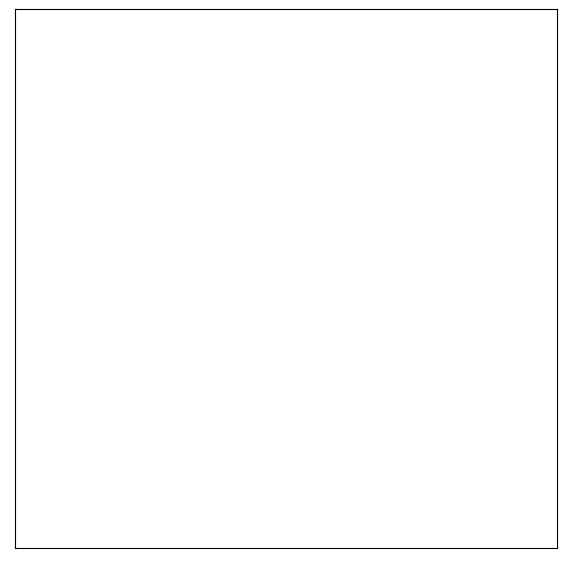

In [9]:
# Graficamos la información usando `matplotlib`
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    #print(all_grid.iloc[i][0])
    
#anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATION)


In [10]:
#anim

In [11]:
if(not ActiveSimulation):
    model=highwayModel(NUM_CARS,GRID_WIDTH,GRID_HIGHT)

TypeError: __init__() missing 1 required positional argument: 'num_generated_cars'

In [12]:
def translate(x,y):
    pos=[1056.305,484.653]
    rotation=80
    #Escalamos x, y
    scales=[-0.1615*x,-4.1988*y]
    #x'= x cost - y sint
    #y'=x sint +y cost
    new_x=scales[0]*math.cos(math.radians(rotation))-scales[1]*math.sin(math.radians(rotation))+pos[0]
    new_y=scales[0]*math.sin(math.radians(rotation))+scales[1]*math.cos(math.radians(rotation))+pos[1]
    return [new_x,new_y]

In [13]:
def handleStep():
    newList=model.carPositionList()
    n=model.time
    res=[]
    for i in newList:
        new_x=i[1]
        new_y=i[2]
        #[new_x,new_y]=translate(i[1],i[2])
        res.append({"id":i[0],"x":new_x,"y":new_y})
     
    model.step()
    return {"positionList":res, "step":n}

In [ ]:
api = Flask(__name__)

#return json.dumps("{ companyList:"+companies+"}")
@api.route('/position', methods=['GET'])
def get_position():
    #return json.dumps(companies)
    return json.dumps(handleStep())
if __name__ == '__main__':
    api.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [30/Nov/2022 13:18:22] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:25] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:26] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:26] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:27] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:27] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:28] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:28] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:28] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:29] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:29] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:29] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:30] "GET /position HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2022 13:18:31] "GET /position HTTP/1.